In [1]:
import numpy as np 
from scipy.special import softmax 
import time 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake, cart_pole
from utils.viz import viz 
viz.get_style()

In [2]:
def show_lr_curves(model_performances, window_size=40, step_unit=100, x_range=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    for lbl, curve in model_performances.items():
        # smooth the learning curve 
        smoothed_curve = np.convolve(curve, np.ones(window_size)/window_size, mode='valid')
        t = np.arange(len(smoothed_curve))
        sns.lineplot(x=t, y=smoothed_curve, ax=ax, label=lbl)
    for pos in ['left', 'bottom']: ax.spines[pos].set_linewidth(3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #ax.set_ylim([0, 105])
    if x_range is not None: ax.set_xlim(x_range)
    ax.set_xlabel(f'Every {step_unit} steps')
    ax.set_ylabel('Reward')
    plt.show()

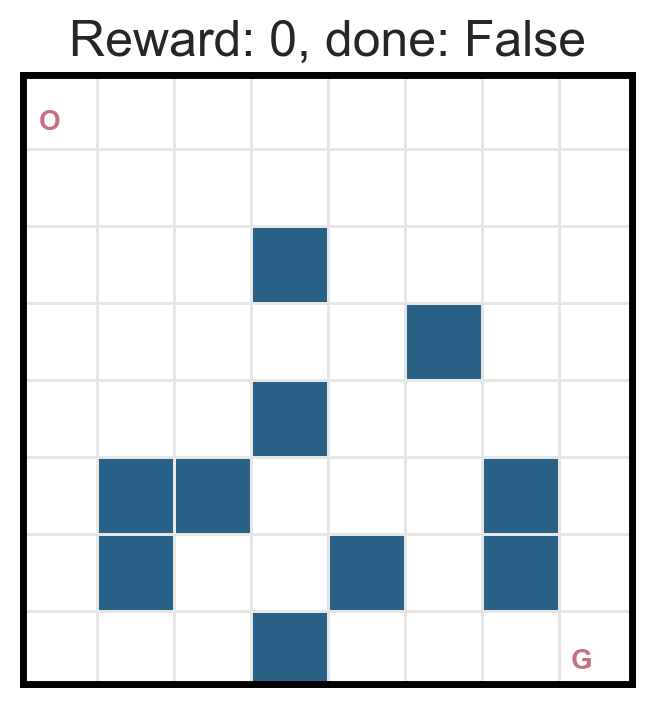

In [3]:
seed = 1234 
env = frozen_lake(seed=seed, Rscale=10)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

# 介绍一下这个frozen_lake的游戏
* env.reset() 重置agent的位置到起始点
* env.step(a) a=[0, 1, 2, 3,] 代表上下左右
* env.p_s_next(s, a) 输入当前state s 和 action a, 输出转移到所有其他state的概率的向量
* env.r(s) 到达某个state时，返回(reward, bool done or not)
* env.s_termination 返回所有的终点的state, 包括窟窿和终点
* env.show_v(ax, V)  把所有状态的value画出来
* env.A, env.S 展示所有的action和state

## 1. REINFORCE

In [4]:
lr_curves = {}

In [5]:
class softmax_policy:
    
    def __init__(self, nS, nA):
        self.nS, self.nA = nS, nA
        self.theta = np.zeros([nS, nA])

    def forward(self, s):
        return softmax(self.theta[s])
    
    def log_grad(self, s, a):
        ''' log gradient of π(a|s) 
            for action==a:  1-π(a|s)
            for action!=a:   -π(a|s)
        '''
        return np.eye(self.nA)[a] - self.forward(s)
    
    def get_pi(self):
        return softmax(self.theta, axis=1)

In [6]:
def REINFORCE(env, policy_strategy, alpha=.1, gamma=.99, 
                  seed=1234, 
                  show_trajectory=False, 
                  show_intval=1000, max_steps=100,
                  step_unit=100, max_step_unit=4000):
    
    # initialize random seed
    rng = np.random.RandomState(seed)
    # init a list to record the model performance per episode
    model_performance = []
    # initialize the policy strategy
    policy = policy_strategy(env.nS, env.nA)

    # loop over episodes 
    epi, end_learn = 0, False
    step_cum, r_cum, n_step_unit = 0, 0, 0
    while not end_learn:
        trajectory = []

        # rollout the episode 
        s, _, _ = env.reset()
        step = 0
        while True:
            a = rng.choice(env.A, p=policy.forward(s))
            s_next, r, done = env.step(a)
            trajectory.append((s, a, r))
            s = s_next
            step += 1
            r_cum += r
            step_cum += 1
            
            if (step_cum+1) % step_unit==0:
                model_performance.append(r_cum)
                step_cum, r_cum = 0, 0
                n_step_unit += 1

            if n_step_unit >= max_step_unit:
                end_learn = True
                break
           
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 2, figsize=(12, 4))
                clear_output(True)
                env.render(ax[0], epi+1, step)
                env.show_pi(ax[1], policy.get_pi())
                time.sleep(.1)
                plt.show()

            if done or (step>max_steps): 
                epi += 1
                break
        
        # update the policy 
        for t, expr in enumerate(trajectory):
            s, a, r = expr
            G = np.sum([gamma**k*i_expr[2] for k, i_expr in enumerate(trajectory[t:])])
            policy.theta[s] += alpha*(gamma**t)*policy.log_grad(s, a)*G

    return policy.get_pi(), model_performance

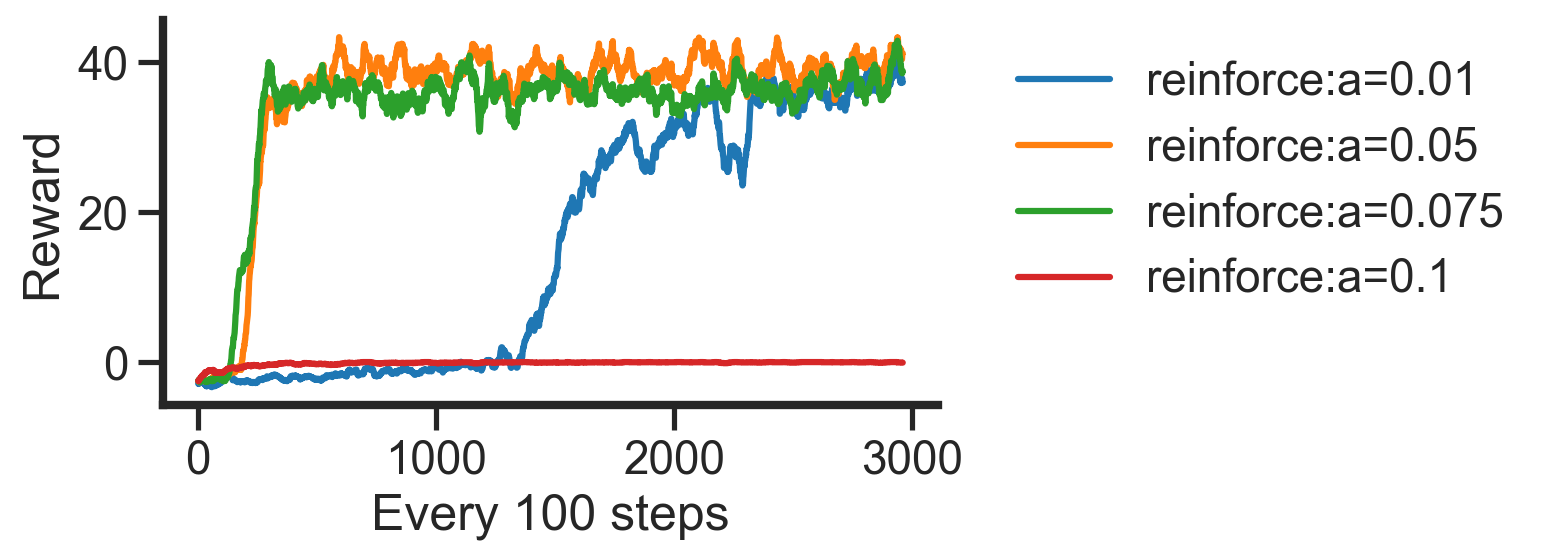

In [7]:
# create the random policy
seed = 1234
for alpha in [.01, .05, .075, .1]: 
    env = frozen_lake(seed=seed, Rscale=10)
    pi_re, mp_re = REINFORCE(env, policy_strategy=softmax_policy, 
                            alpha=alpha,
                            seed=seed+1,
                            show_trajectory=False,
                            max_step_unit=3000)
    lr_curves[f'reinforce:a={alpha}'] = mp_re
show_lr_curves(lr_curves)

In [8]:
## remove the variants other than the best one
for alpha in [.01, .075, .1]: del lr_curves[f'reinforce:a={alpha}']

## 2. Actor-Critic


### 2.1 Classical Actor-Critic

In [9]:
def Actor_Critic(env, policy_strategy, 
                  alpha_v=.1, alpha_theta=.1, gamma=.99, 
                  seed=1234, 
                  show_trajectory=False, 
                  show_intval=1000, max_steps=100,
                  step_unit=100, max_step_unit=4000):
    
    # initialize random seed
    rng = np.random.RandomState(seed)
    # init a list to record the model performance per episode
    model_performance = []
    # initialize the policy strategy
    actor = policy_strategy(env.nS, env.nA)
    v_critic = np.zeros([env.nS])

    # loop over episodes 
    epi, end_learn = 0, False
    step_cum, r_cum, n_step_unit = 0, 0, 0
    while not end_learn:

        # rollout the episode 
        s, _, _ = env.reset()
        step = 0
        I = 1 
        while True:
            
            # interacte with the environment
            a = rng.choice(env.A, p=actor.forward(s))
            s_next, r, done = env.step(a)

            # update the agent 
            v_tar = r + gamma*(1-done)*np.max(v_critic[s_next])
            delta = v_tar - v_critic[s]
            v_critic[s] = v_critic[s] + alpha_v*delta 
            q = v_tar
            actor.theta[s] += alpha_theta*I*actor.log_grad(s, a)*q
            I *= gamma
            s = s_next

            # for evaluation
            step += 1
            r_cum += r
            step_cum += 1
            
            if (step_cum+1) % step_unit==0:
                model_performance.append(r_cum)
                step_cum, r_cum = 0, 0
                n_step_unit += 1

            if n_step_unit >= max_step_unit:
                end_learn = True
                break
           
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                clear_output(True)
                env.render(ax[0], epi+1, step)
                env.show_v(ax[1], v_critic)
                env.show_pi(ax[2], actor.get_pi())
                time.sleep(.1)
                plt.show()

            if done or (step>max_steps): 
                epi += 1
                break
        
    return actor.get_pi(), model_performance

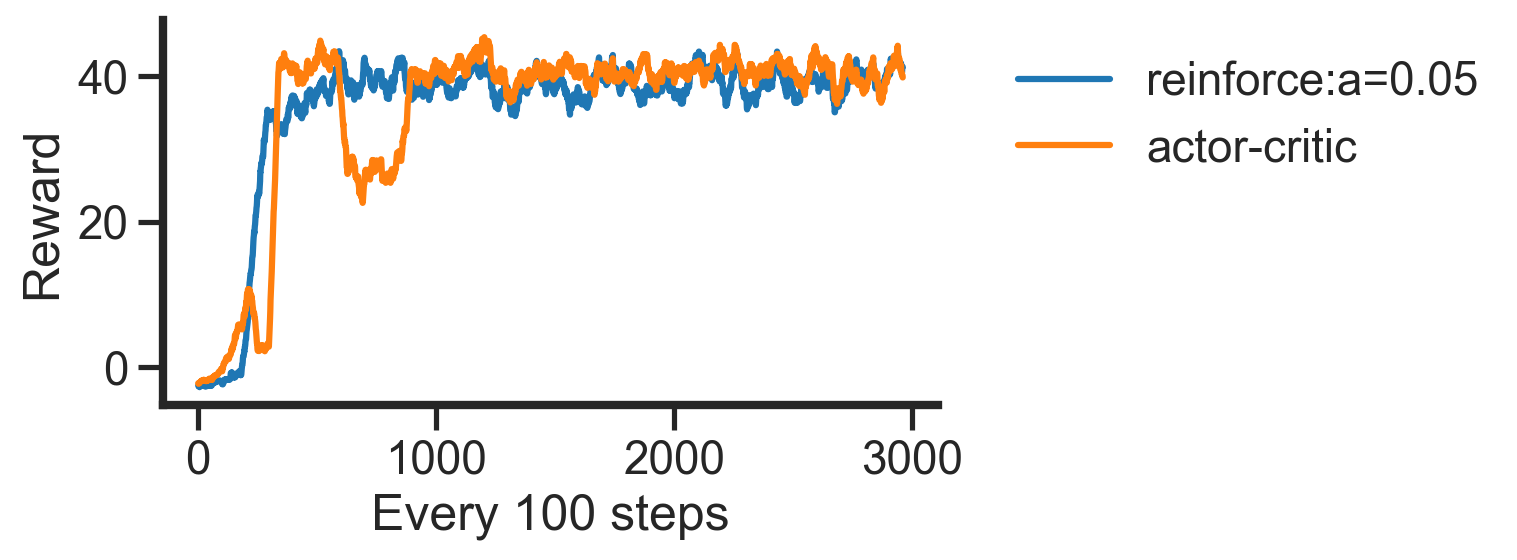

In [10]:
# create the random policy
seed = 1234
env = frozen_lake(seed=seed, Rscale=10)
alpha_v, alpha_theta = .1, .2
pi, mp = Actor_Critic(env, policy_strategy=softmax_policy, 
                        alpha_v=alpha_v,
                        alpha_theta=alpha_theta,
                        seed=seed+1,
                        show_trajectory=False,
                        max_step_unit=3000)
lr_curves[f'actor-critic'] = mp
show_lr_curves(lr_curves)

### 2.2 Advantage Actor-Critic

In [12]:
def Adv_Actor_Critic(env, policy_strategy, 
                  alpha_v=.1, alpha_theta=.1, gamma=.99, 
                  seed=1234, 
                  show_trajectory=False, 
                  show_intval=1000, max_steps=100,
                  step_unit=100, max_step_unit=4000):
    
    # initialize random seed
    rng = np.random.RandomState(seed)
    # init a list to record the model performance per episode
    model_performance = []
    # initialize the policy strategy
    actor = policy_strategy(env.nS, env.nA)
    v_critic = np.zeros([env.nS])

    # loop over episodes 
    epi, end_learn = 0, False
    step_cum, r_cum, n_step_unit = 0, 0, 0
    while not end_learn:

        # rollout the episode 
        s, _, _ = env.reset()
        step = 0
        I = 1 
        while True:
            # interact with the environment
            a = rng.choice(env.A, p=actor.forward(s))
            s_next, r, done = env.step(a)
            # update the agent 
            v_tar = r + gamma*(1-done)*np.max(v_critic[s_next])
            delta = v_tar - v_critic[s]
            v_critic[s] = v_critic[s] + alpha_v*delta 
            actor.theta[s] += alpha_theta*I*actor.log_grad(s, a)*delta
            I *= gamma
            s = s_next

            # for evaluation
            step += 1
            r_cum += r
            step_cum += 1
            
            if (step_cum+1) % step_unit==0:
                model_performance.append(r_cum)
                step_cum, r_cum = 0, 0
                n_step_unit += 1

            if n_step_unit >= max_step_unit:
                end_learn = True
                break
           
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                clear_output(True)
                env.render(ax[0], epi+1, step)
                env.show_v(ax[1], v_critic)
                env.show_pi(ax[2], actor.get_pi())
                time.sleep(.1)
                plt.show()

            if done or (step>max_steps): 
                epi += 1
                break
        
    return actor.get_pi(), model_performance

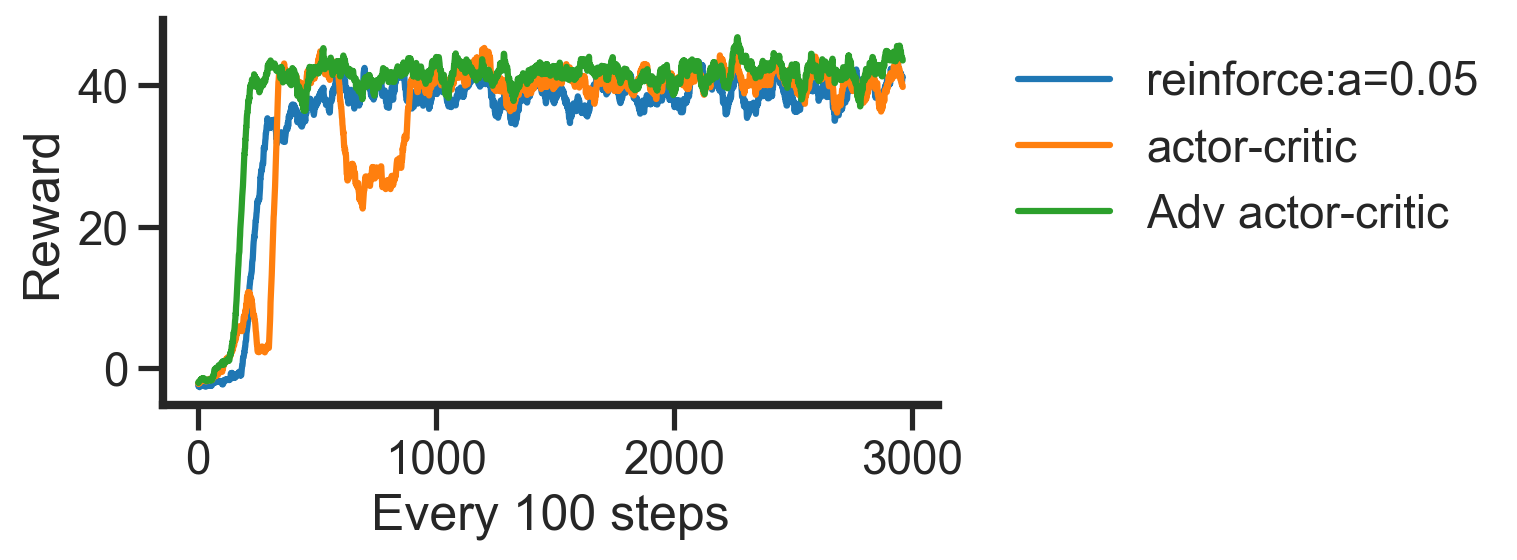

In [13]:
# create the random policy
seed = 1234
env = frozen_lake(seed=seed, Rscale=10)
alpha_v, alpha_theta = .2, .2
pi, mp = Adv_Actor_Critic(env, policy_strategy=softmax_policy, 
                        alpha_v=alpha_v,
                        alpha_theta=alpha_theta,
                        seed=seed+1,
                        show_trajectory=False,
                        show_intval=200,
                        max_step_unit=3000)
lr_curves[f'Adv actor-critic'] = mp
show_lr_curves(lr_curves)

In [14]:
def Sarsa(env, pi, policy_strategy, alpha=.1, gamma=.99, 
                  seed=1234, n_episodes=15000, 
                  show_trajectory=False, 
                  show_intval=1000, max_steps=100, 
                  step_unit=100, max_step_unit=4000):
    
    # initialization 
    rng = np.random.RandomState(seed)
    q = np.zeros([env.nS, env.nA])
    v = np.zeros([env.nS])
    policy = policy_strategy(n_episodes)
    model_performance = []

    # loop over episodes 
    epi, end_learn = 0, False
    step_cum, r_cum, n_step_unit = 0, 0, 0
    while not end_learn:

        policy.epi = epi
        s, _, _ = env.reset()
        a = rng.choice(env.A, p=pi[s])
        step = 0
        while True:
            # interact with the env
            s_next, r, done = env.step(a)
            a_next = rng.choice(env.A, p=pi[s_next])
            q_tar = r + gamma*(1-done)*q[s_next, a_next]
            q[s, a] = q[s, a] + alpha*(q_tar - q[s, a])
            # improve policy 
            pi[s] = policy(q[s])
            # calculate the value function (just for visualization)
            v[s] = np.sum(pi[s]*q[s])  
            s, a = s_next, a_next
            # for evaluation
            step += 1
            r_cum += r
            step_cum += 1

            if (step_cum+1) % step_unit==0:
                model_performance.append(r_cum)
                step_cum, r_cum = 0, 0
                n_step_unit += 1

            if n_step_unit >= max_step_unit:
                end_learn = True
                break
            
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                clear_output(True)
                env.render(ax[0], epi+1, step)
                env.show_v(ax[1], v)
                env.show_pi(ax[2], pi)
                time.sleep(.1)
                plt.show()

            if done or (step>max_steps): 
                epi += 1
                break

    return pi, model_performance

In [15]:
class e_greedy:
    '''epsilon-greedy policy

    The policy has epsilon probability to choose a random action,

    for example
        given q[s] = [.3, .9, .9, .1], the 2nd and 3rd action are tied,
        then the greedy policy should be [0, .5, .5, 0]

        assuming that epsilon = 0.1, then the policy should be 

        [0.025, 0.475, 0.475, 0.025]
    '''
    def __init__(self, n_episodes, eps=0.3):
        self.n_episodes = n_episodes
        self.eps = eps

    def __call__(self, q):
        # random policy
        pi_rand = np.ones(env.nA) / env.nA
        # greedy policy 
        qmax = q==np.max(q)
        pi_greedy = qmax / qmax.sum()
        return self.eps*pi_rand + (1-self.eps)*pi_greedy

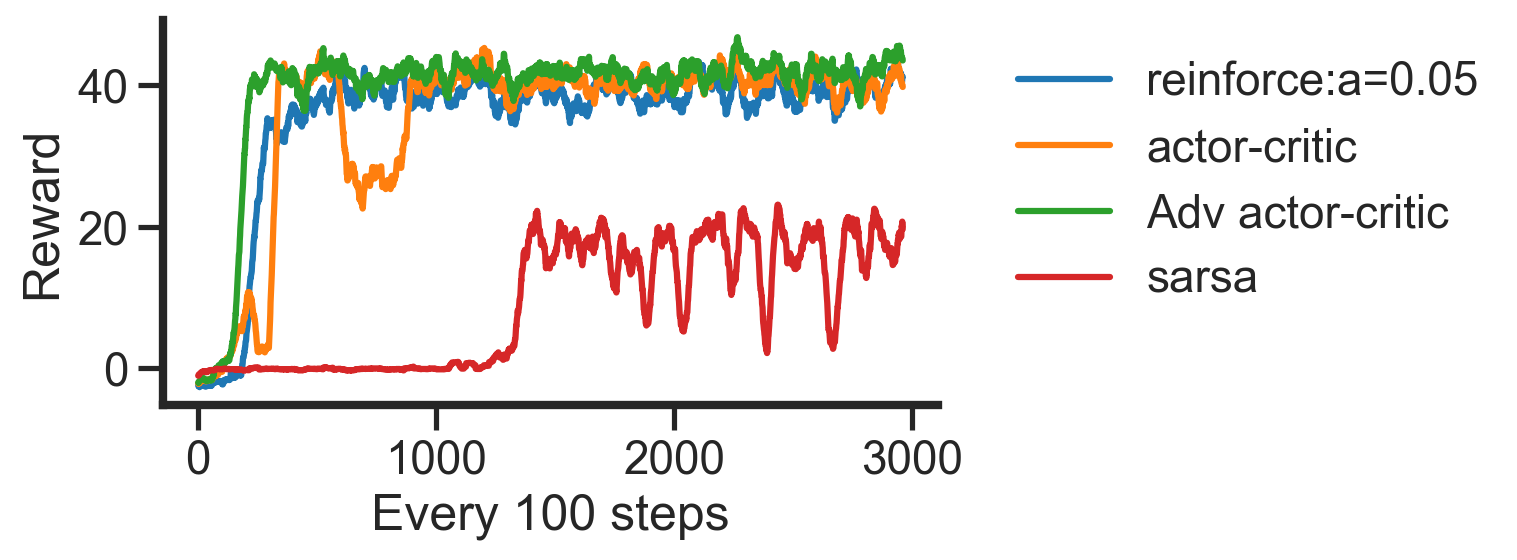

In [16]:
seed = 1234 
rng = np.random.RandomState(seed)
pi_rand = softmax(np.zeros([env.nS, env.nA]), axis=1)
env = frozen_lake(seed=seed, Rscale=10)
pi_sarsa, pg_sarsa = Sarsa(env, pi_rand, 
                            alpha=.08,
                            policy_strategy=e_greedy, 
                            show_trajectory=False,
                            max_step_unit=3000)
lr_curves['sarsa'] = pg_sarsa
show_lr_curves(lr_curves)

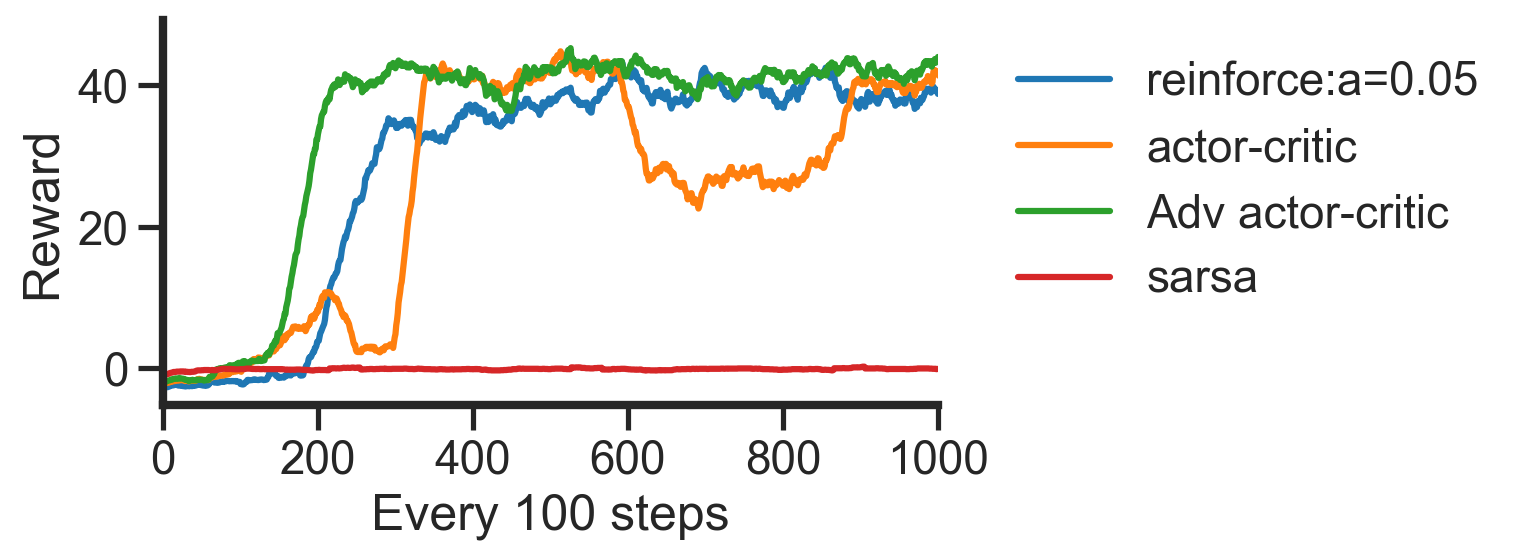

In [17]:
show_lr_curves(lr_curves, x_range=(0, 1000))

## 3. Continuous Action Space


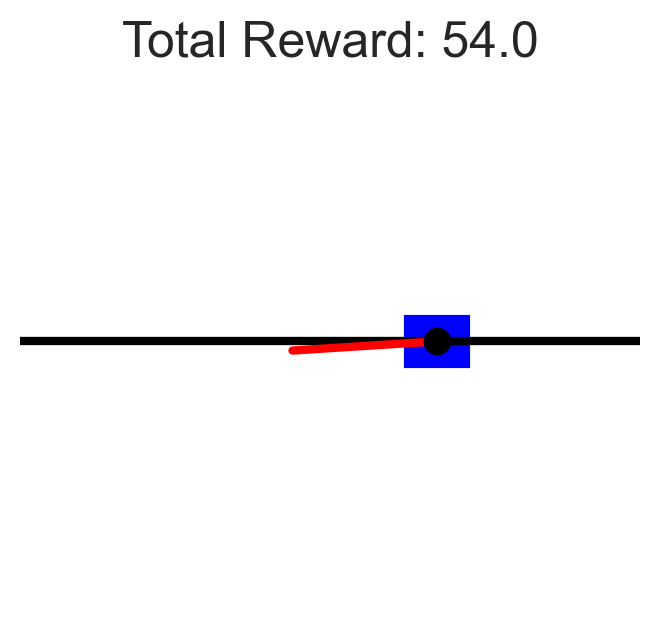

In [2]:
env = cart_pole()
s, _, done = env.reset()
total_reward = 0
while not done:
    
    # Sample a random continuous action (force between -1 and 1)
    action = np.random.uniform(-1.0, 1.0)
    next_s, r, done = env.step(action)
    total_reward += r
    
    # visualize
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    clear_output(True)
    env.render(ax)
    ax.set_title(f'Total Reward: {total_reward}')
    plt.show()
    time.sleep(0.05)

# --------  Optional Section  ----------

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
class neural_net_policy(nn.Module):

    def __init__(self, nS, nA, alpha, gamma, hidden_dim=128):
        super().__init__()
        self.gamma = gamma
        self.l1 = nn.Linear(nS, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, nA)
        self.logsig = nn.Parameter(torch.zeros(nA))
        # optimizer 
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, s):
        # state -> action (mean of Gaussian)
        x = torch.relu(self.l1(s))
        x = torch.relu(self.l2(x))
        return torch.tanh(self.l3(x)), self.logsig
    
    def get_action(self, s):
        s = torch.from_numpy(s).float().unsqueeze(0)
        mu, logsig = self.forward(s)
        dist = torch.distributions.Normal(mu, logsig.exp())
        a = dist.sample()
        log_prob = dist.log_prob(a)
        return a.numpy()[0, 0], log_prob.sum()
    
    def update(self, log_probs, rs):
        # compute returns 
        returns = []
        G = 0
        for r in reversed(rs):
            G = r + self.gamma * G
            returns.insert(0, G)
        # tensorize 
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        log_probs = torch.hstack(log_probs)
        # compute loss 
        loss = -(returns * log_probs).mean()
        # update 
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [7]:
class random_policy:

    def __init__(self, nS, nA, alpha, gamma, hidden_dim=128):
        pass

    def get_action(self, s):
        return np.random.uniform(-1.0, 1.0), 0
    
    def update(self, log_probs, rs):
        pass

In [8]:
def REINFORCE(env, policy_strategy, alpha=.1, gamma=.99, 
                  seed=1234, 
                  show_trajectory=False, 
                  show_intval=200, max_steps=300,
                  max_episodes=10000):
    
    # initialize random seed
    torch.manual_seed(seed)    
    # init a list to record the model performance per episode
    model_performance = []
    # initialize the policy strategy
    policy = policy_strategy(env.nS, 1, alpha, gamma)

    # loop over episodes 
    for epi in range(max_episodes):

        # rollout the episode 
        s, _, _ = env.reset()
        log_probs, rs = [], [] 
        step = 0
        total_reward = 0
        while True:
            a, log_prob = policy.get_action(s)
            s_next, r, done = env.step(a)
            log_probs.append(log_prob)
            rs.append(r)
            s = s_next
            step += 1
            total_reward += r
                       
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 1, figsize=(4, 4))
                clear_output(True)
                env.render(ax)
                ax.set_title(f'Epi: {epi+1}, Reward: {total_reward}')
                plt.show()
                time.sleep(0.05)

            if done or (step>max_steps): 
                model_performance.append(total_reward)
                break
        
        # update the policy 
        policy.update(log_probs, rs)

    return model_performance

In [9]:
lr_curves = {}

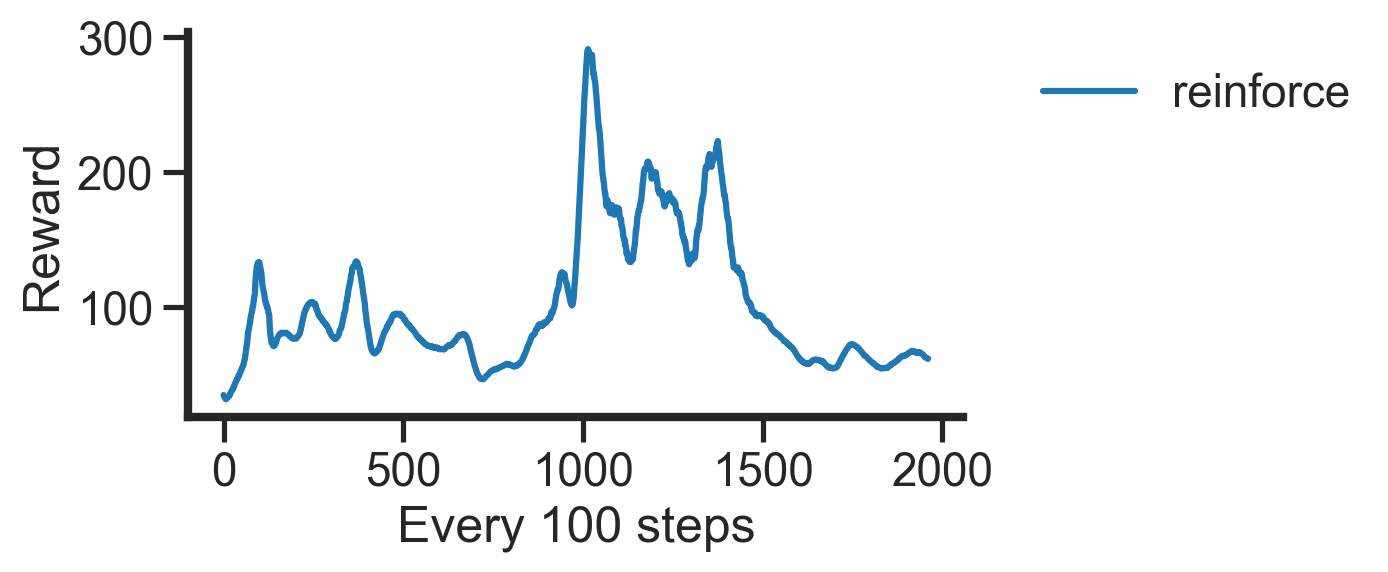

In [12]:
seed = 98
env = cart_pole(seed)
mp = REINFORCE(env, policy_strategy=neural_net_policy, 
                        alpha=.005,
                        seed=seed+1,
                        show_trajectory=False,
                        max_episodes=2000)
lr_curves['reinforce'] = mp
show_lr_curves(lr_curves)

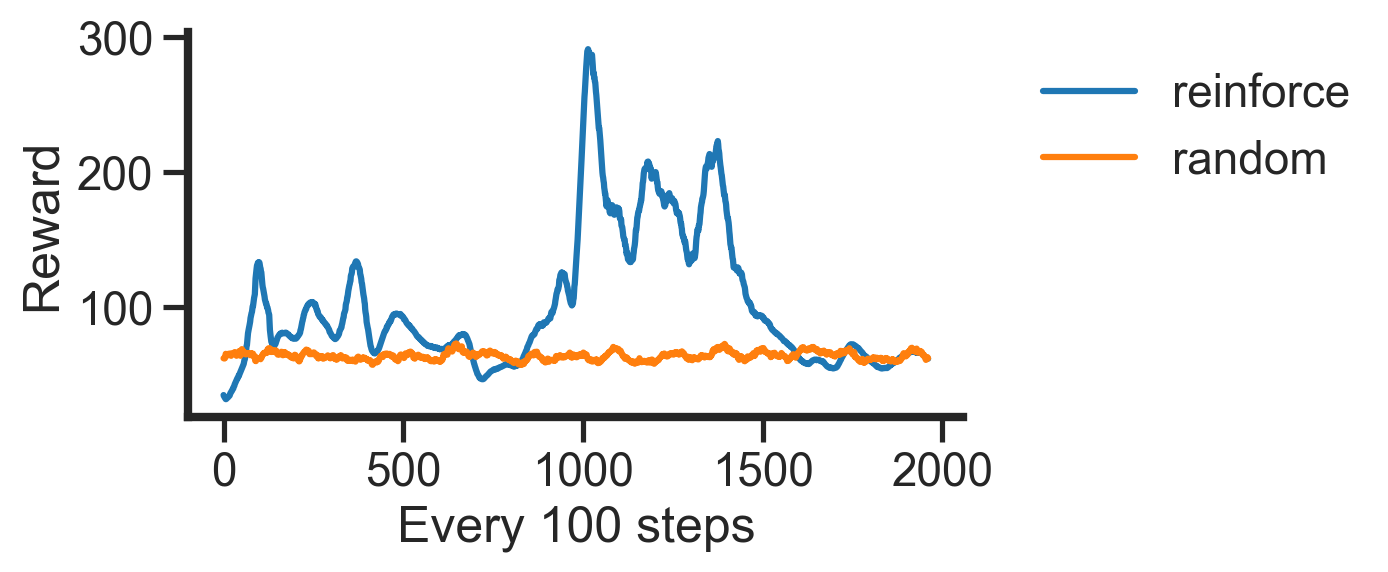

In [13]:
seed = 98
np.random.seed(seed)
env = cart_pole()
mp = REINFORCE(env, policy_strategy=random_policy, 
                        alpha=.005,
                        seed=seed+1,
                        show_trajectory=False,
                        max_episodes=2000)
lr_curves['random'] = mp
show_lr_curves(lr_curves)

In [14]:
class Actor(nn.Module):
    def __init__(self, nS, nA, alpha, hidden_dim=128):
        super().__init__()
        self.l1 = nn.Linear(nS, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, nA)
        self.logsig = nn.Parameter(torch.zeros(nA))
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, s):
        x = torch.relu(self.l1(s))
        x = torch.relu(self.l2(x))
        return torch.tanh(self.l3(x)), self.logsig

    def get_action(self, s):
        s = torch.from_numpy(s).float().unsqueeze(0)
        mu, logsig = self.forward(s)
        dist = torch.distributions.Normal(mu, logsig.exp())
        a = dist.sample()
        log_prob = dist.log_prob(a).sum()
        return a.detach().numpy()[0, 0], log_prob

class Critic(nn.Module):
    def __init__(self, nS, alpha, hidden_dim=128):
        super().__init__()
        self.l1 = nn.Linear(nS, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, s):
        x = torch.relu(self.l1(s))
        x = torch.relu(self.l2(x))
        return self.l3(x).squeeze()

class actor_critic_policy:
    def __init__(self, nS, nA, alpha_actor=1e-4, alpha_critic=1e-4, gamma=0.99, hidden_dim=128):
        self.actor = Actor(nS, nA, alpha_actor, hidden_dim)
        self.critic = Critic(nS, alpha_critic, hidden_dim)
        self.gamma = gamma

    def get_action(self, s):
        action, log_prob = self.actor.get_action(s)
        return action, log_prob

    def update(self, log_prob, s, r, s_next, done):
        s = torch.from_numpy(s).float().unsqueeze(0)
        s_next = torch.from_numpy(s_next).float().unsqueeze(0)
        v = self.critic.forward(s)
        v_next = self.critic.forward(s_next)

        # Compute TD targets and advantages 
        with torch.no_grad():
            next_state_values = v_next * (1 - done)
            q = r + self.gamma * next_state_values
            advantage = q - v

        # Actor loss
        actor_loss = -(advantage * log_prob).mean()

        # Critic loss
        critic_loss = (q - v).square().mean()

        # Update actor
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        # Update critic
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()


In [15]:
def actor_critic(env, policy_strategy, 
                  alpha_critic=.1, alpha_actor=.1,
                  gamma=.99, 
                  seed=1234, 
                  show_trajectory=False, 
                  show_intval=200, max_steps=300,
                  max_episodes=10000):
    
    # initialize random seed
    torch.manual_seed(seed)    
    # init a list to record the model performance per episode
    model_performance = []
    # initialize the policy strategy
    ac_agent = policy_strategy(env.nS, 1, 
                               alpha_critic=alpha_critic, 
                               alpha_actor=alpha_actor, 
                               gamma=gamma)

    # loop over episodes 
    for epi in range(max_episodes):

        # rollout the episode 
        s, _, _ = env.reset()
        step = 0
        total_reward = 0
        while True:
            a, log_prob = ac_agent.get_action(s)
            s_next, r, done = env.step(a)
            # update the policy 
            ac_agent.update(log_prob, s, r, s_next, done)

            s = s_next
            step += 1
            total_reward += r
                       
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 1, figsize=(4, 4))
                clear_output(True)
                env.render(ax)
                ax.set_title(f'Epi: {epi+1}, Reward: {total_reward}')
                plt.show()
                time.sleep(0.05)

            if done or (step>max_steps): 
                model_performance.append(total_reward)
                break
        
        
    return model_performance

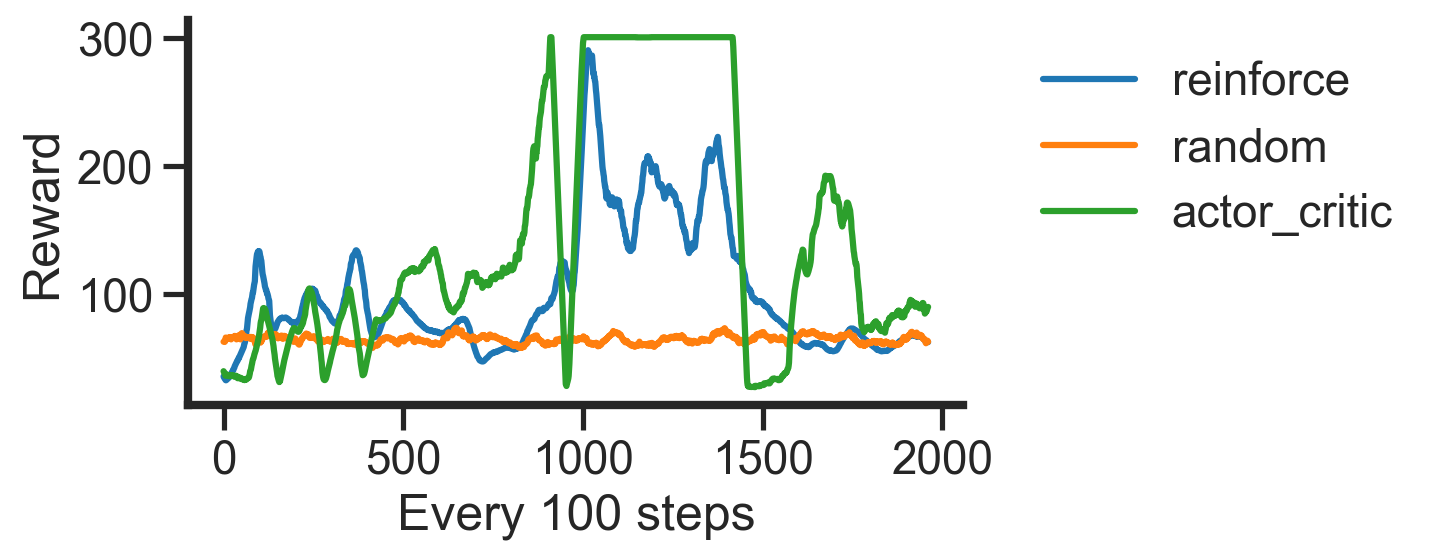

In [18]:
seed = 98
env = cart_pole(seed)
mp = actor_critic(env, policy_strategy=actor_critic_policy, 
                        alpha_critic=1e-3,
                        alpha_actor=1e-4,
                        show_trajectory=False,
                        max_episodes=2000)
lr_curves['actor_critic'] = mp
show_lr_curves(lr_curves)